In [1]:
import sys
sys.path.insert(0, "..") # add parent CNODE package to sys.path

import numpy as np
import matplotlib.pyplot as plt
from datasets.vdpo_dataset_np import create_vdpo_dataset
from src.nn_pyomo_base import NeuralODEPyomo

## 1. Create dataset of VDPO state vectors

Full grid shape: (399,)
Train grid shape: (200,)
Test grid shape: (200,)
Y_true shape: (399, 2)
Y_obs shape: (200, 2)
Y_obs displacement average value: 0.45
Y_obs velocity average value: 0.25
Y_obs displacement range: [-2.42, 2.55]
Y_obs velocity range: [-3.78, 3.81]


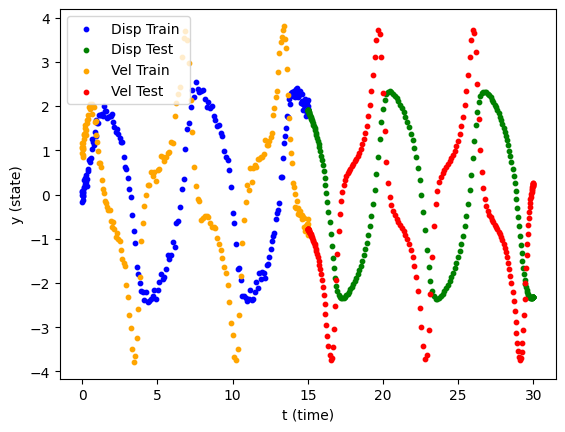

In [2]:
train_interpol, test_interpol, full_grid, Y_true, train_grid, Y_obs, Y_smooth, test_grid, Y_test = create_vdpo_dataset(num_nodes=400, end_time=30, noise_sd=0.1)

# Print dataset shapes and summary stats 
print(f"Full grid shape: {full_grid.shape}")
print(f"Train grid shape: {train_grid.shape}")
print(f"Test grid shape: {test_grid.shape}")
print(f"Y_true shape: {Y_true.shape}")
print(f"Y_obs shape: {Y_obs.shape}")
print(f"Y_obs displacement average value: {np.mean(Y_obs[:, 0]):.2f}")
print(f"Y_obs velocity average value: {np.mean(Y_obs[:, 1]):.2f}")
print(f"Y_obs displacement range: [{Y_obs[:, 0].min():.2f}, {Y_obs[:, 0].max():.2f}]")
print(f"Y_obs velocity range: [{Y_obs[:, 1].min():.2f}, {Y_obs[:, 1].max():.2f}]")

# Visualise trajectories from train and test datasets 
plt.figure()
plt.scatter(train_grid, Y_obs[:, 0], color='blue', marker='o', s=10, label="Disp Train ")
plt.scatter(test_grid, Y_test[:, 0], color='green', marker='o', s=10, label="Disp Test")
plt.scatter(train_grid, Y_obs[:, 1], color='orange', marker='o', s=10, label="Vel Train ")
plt.scatter(test_grid, Y_test[:, 1], color='red', marker='o', s=10, label="Vel Test")
plt.xlabel('t (time)')
plt.ylabel('y (state)')
plt.legend()

## 2. Optimise pyomo model using IPOPT (train the neural ODE)

In [ ]:
T = train_grid[-1] - train_grid[0]
layer_sizes = [2, 32, 2] 

# Compute collocation-estimated differentiation matrix on the train grid 
D = train_interpol.compute_derivative_matrix() # (half_nodes, half_nodes)
print(f"Differentiation matrix shape: {D.shape}")

# Compute quadrature weights for integrated residual loss if applicable 
quad_ws = train_interpol.compute_clenshaw_curtis_quadrature_weights() # (half_nodes, )
print(f"Quadrature weights shape: {quad_ws.shape}")

pyo_model_dc = NeuralODEPyomo(
    Y_obs, D, layer_sizes, 
    state_lower_bound=-100,
    state_upper_bound=100,
    param_lower_bound=-100,
    param_upper_bound=100,
    lambda_reg=1e-4, 
    Y_smooth=Y_smooth, 
    transcription_method='dc'
)
pyo_model_dc.solve_model()

pyo_model_irrdc = NeuralODEPyomo(
    Y_obs, D, layer_sizes, 
    state_lower_bound=-100,
    state_upper_bound=100,
    param_lower_bound=-100,
    param_upper_bound=100,
    lambda_reg=1e-4, 
    Y_smooth=Y_smooth, 
    transcription_method='irrdc',
    rho_reg=0.1,
    quadrature_weights=quad_ws
)
pyo_model_irrdc.solve_model()

Differentiation matrix shape: (200, 200)
Quadrature weights shape: (200,)
Y_star variable average: 0.3510, 
Y_star variable range: [-3.7431, 3.7542]
Initial MSE: 0.0092
Initial regularised l2 norm: 0.0006
Solver available?: True

Initial NN parameter summary stats (pre-IPOPT): 
Layer 1: W range [-0.2799, 0.4691], |W| mean 0.1671
Layer 1: b range [0.0168, 0.0168], |b| mean 0.0168
Layer 2: W range [-0.5539, 0.4440], |W| mean 0.1937
Layer 2: b range [-0.0501, -0.0501], |b| mean 0.0501
Ipopt 3.14.19: max_iter=3000
tol=1e-06
acceptable_tol=0.0001
acceptable_iter=15
nlp_scaling_method=gradient-based
mu_strategy=adaptive
print_level=5


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
********************************************************

## 3. Use the trained model as RHS of an ODE system 

In [ ]:
y0_train = Y_obs[0, :]
y0_test = Y_test[0, :]

predicted_trajectory_train_irrdc = pyo_model_irrdc.get_predicted_trajectory(y0_train, train_grid, rtol=1e-7, atol=1e-9, max_step=(train_grid[1]-train_grid[0]))
predicted_trajectory_test_irrdc = pyo_model_irrdc.get_predicted_trajectory(y0_test, test_grid, rtol=1e-7, atol=1e-9, max_step=(test_grid[1]-test_grid[0]))

predicted_trajectory_train_dc = pyo_model_dc.get_predicted_trajectory(y0_train, train_grid, rtol=1e-7, atol=1e-9, max_step=(train_grid[1]-train_grid[0]))
predicted_trajectory_test_dc = pyo_model_dc.get_predicted_trajectory(y0_test, test_grid, rtol=1e-7, atol=1e-9, max_step=(test_grid[1]-test_grid[0]))

## 4. Plot predicted trajectories over train and test set 

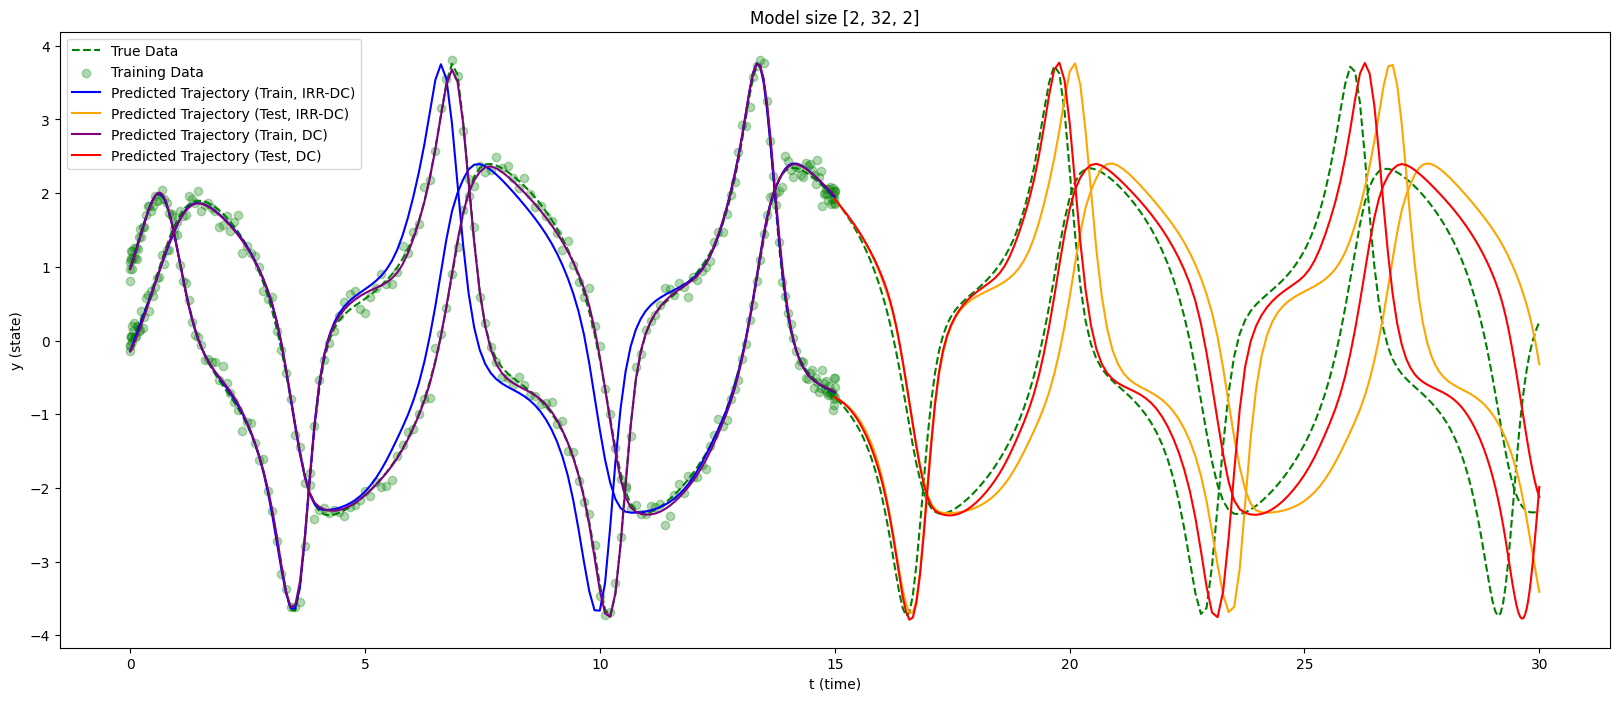

In [ ]:
plt.figure(figsize=(20, 8))
plt.title(f"Model size {layer_sizes}")

# plot true trajectory 
plt.plot(full_grid, Y_true[:, 0], color='green', linestyle='--', label="True Data")
plt.plot(full_grid, Y_true[:, 1], color='green', linestyle='--')

# plot training data
plt.scatter(train_grid, Y_obs[:, 0], color='green', marker='o', alpha=0.3, label="Training Data")
plt.scatter(train_grid, Y_obs[:, 1], color='green', marker='o', alpha=0.3)

# plot predicted trajectories (train and test for both dc and iirdc)
plt.plot(train_grid, predicted_trajectory_train_irrdc[:, 0], color='blue', label="Predicted Trajectory (Train, IRR-DC)")
plt.plot(train_grid, predicted_trajectory_train_irrdc[:, 1], color='blue')
plt.plot(test_grid, predicted_trajectory_test_irrdc[:, 0], color='orange', label="Predicted Trajectory (Test, IRR-DC)")
plt.plot(test_grid, predicted_trajectory_test_irrdc[:, 1], color='orange')

plt.plot(train_grid, predicted_trajectory_train_dc[:, 0], color='purple', label="Predicted Trajectory (Train, DC)")
plt.plot(train_grid, predicted_trajectory_train_dc[:, 1], color='purple')
plt.plot(test_grid, predicted_trajectory_test_dc[:, 0], color='red', label="Predicted Trajectory (Test, DC)")
plt.plot(test_grid, predicted_trajectory_test_dc[:, 1], color='red')

# plot optimised Y_star values at collocation nodes
'''plt.plot(train_grid, Y_star_values[:, 0], 'g-.', linewidth=1, label="$Y_*$ disp")
plt.plot(train_grid, Y_star_values[:, 1], 'r-.', linewidth=1, label="$Y_*$ vel")'''

plt.xlabel('t (time)')
plt.ylabel('y (state)')
plt.legend()

## 5. Plot ODE residuals 

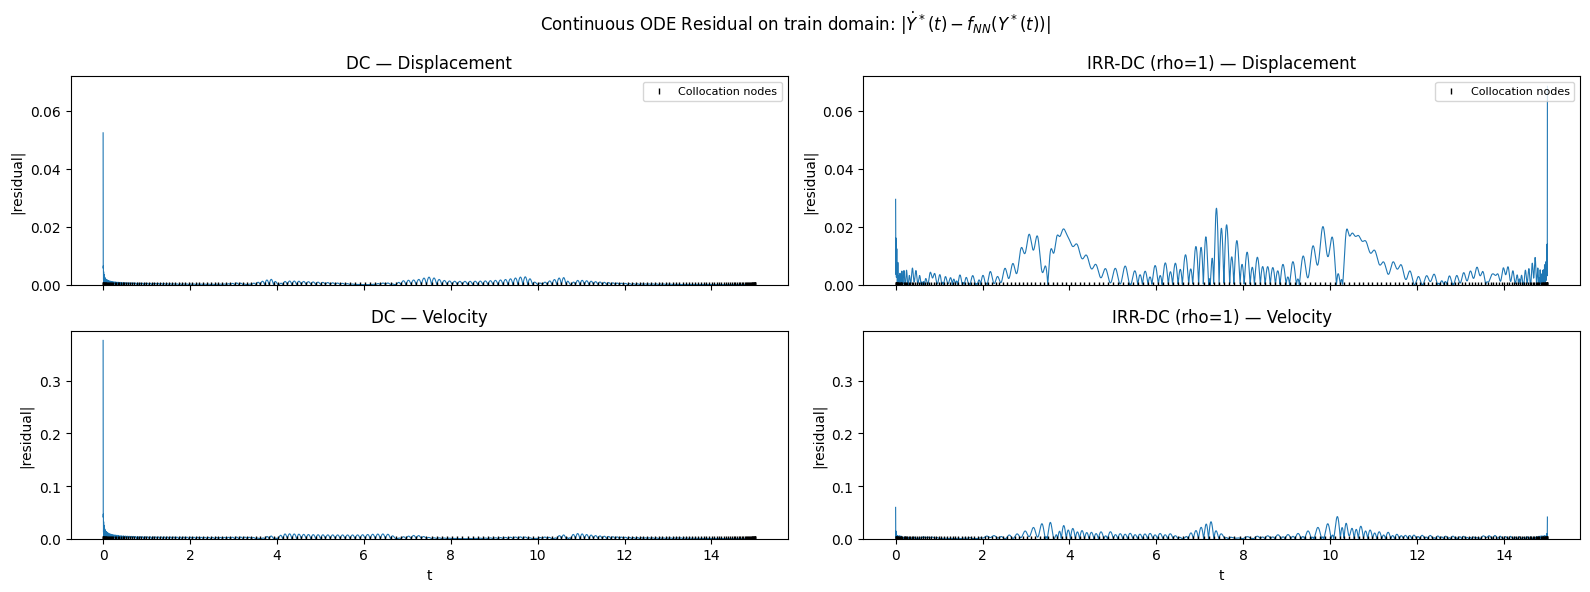

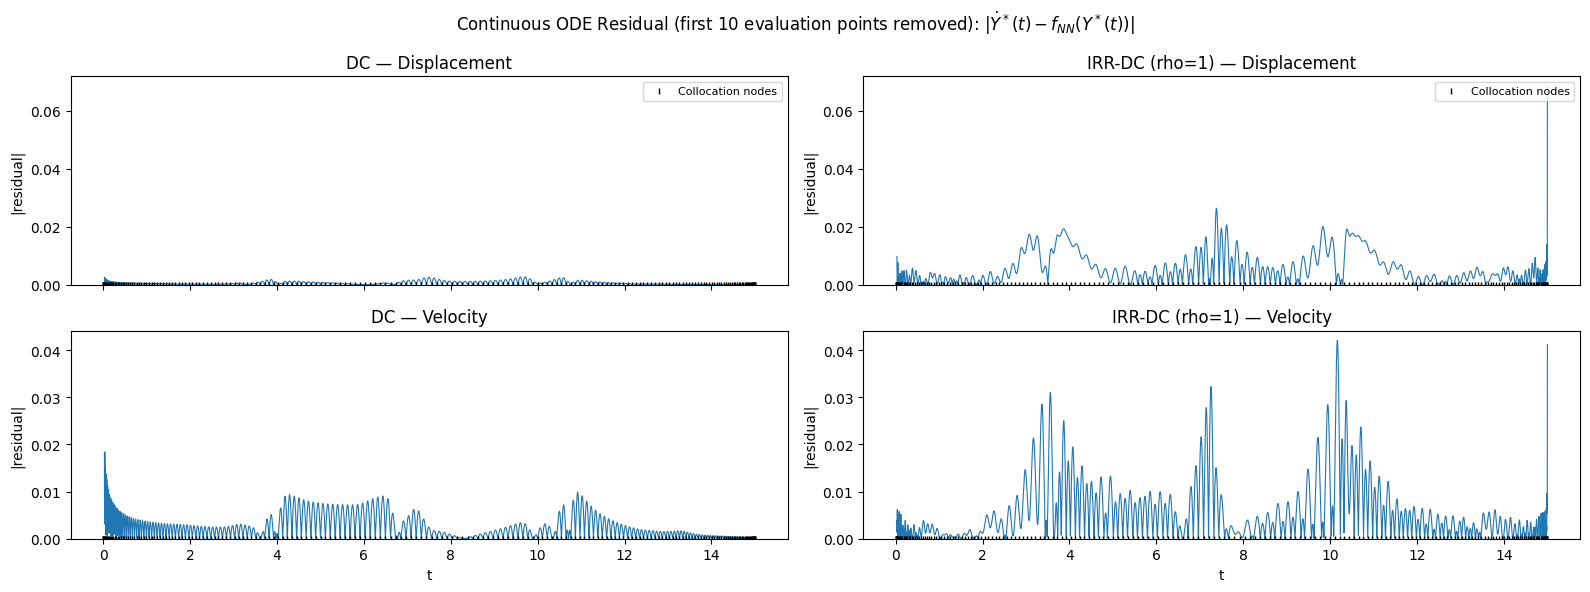

In [ ]:
from scipy.interpolate import BarycentricInterpolator

def evaluate_nn_rhs(pyo_model, Y_vals):
    """Evaluate NN RHS f_NN(Y) for a batch of states Y_vals (N, state_dim)."""
    Ws = pyo_model.convert_weights()
    bs = pyo_model.convert_biases()
    return np.array([pyo_model.nn_prediction(0, Y_vals[i], Ws, bs) for i in range(len(Y_vals))])

def get_model_label_with_rho(base_label, pyo_model):
    """Append rho_reg to label if present on model."""
    rho_val = getattr(pyo_model, 'rho_reg', None)

    if rho_val is None and hasattr(pyo_model, 'model') and hasattr(pyo_model.model, 'rho_reg'):
        try:
            rho_val = pyo_model.model.rho_reg.value
        except Exception:
            rho_val = None

    if rho_val is None:
        return base_label

    try:
        rho_fmt = f"{float(rho_val):g}"
    except Exception:
        rho_fmt = str(rho_val)

    return f"{base_label} (rho={rho_fmt})"

def compute_ode_residual_train(pyo_model, train_grid, num_eval_points=5000, skip_initial_points=10):
    """
    Compute ODE residual r(t) = dY*/dt - f_NN(Y*(t)) on a dense grid over the
    training domain, excluding t=0 and skipping the first few evaluation points
    to reduce initialization artifacts.
    """
    # Extract collocation solution and ODE LHS at all collocation nodes
    Y_star = pyo_model.pyomo_var_to_numpy(
        pyo_model.model.Y_star,
        (pyo_model.num_nodes, pyo_model.state_dim)
    )
    DY_star = pyo_model.pyomo_var_to_numpy(
        pyo_model.model.ode_lhs,
        (pyo_model.num_nodes, pyo_model.state_dim)
    )

    # Dense evaluation grid on train-domain (skip first point to remove t=0 artifact)
    t_cont = np.linspace(train_grid[0], train_grid[-1], num_eval_points)

    # Barycentric interpolation from collocation nodes to dense grid
    interp = lambda vals, d: BarycentricInterpolator(train_grid, vals[:, d])(t_cont)
    DY_cont = np.column_stack([interp(DY_star, d) for d in range(pyo_model.state_dim)])
    Y_cont = np.column_stack([interp(Y_star, d) for d in range(pyo_model.state_dim)])

    f_NN_cont = evaluate_nn_rhs(pyo_model, Y_cont)
    return t_cont, DY_cont - f_NN_cont


def set_common_row_ylims(axes_arr, res_left, res_right, trim_start=0, pad_frac=0.05):
    """Set identical y-scale across DC/IRR-DC columns for each state row."""
    res_left_use = np.abs(res_left[trim_start:]) if trim_start > 0 else np.abs(res_left)
    res_right_use = np.abs(res_right[trim_start:]) if trim_start > 0 else np.abs(res_right)

    for row in range(res_left.shape[1]):
        max_val = max(np.max(res_left_use[:, row]), np.max(res_right_use[:, row]))
        ymax = max_val * (1 + pad_frac) if max_val > 0 else 1e-12
        for col in range(axes_arr.shape[1]):
            axes_arr[row, col].set_ylim(0.0, ymax)


# ---------- Train-domain continuous residual ----------
t_cont_dc, res_train_dc = compute_ode_residual_train(pyo_model_dc, train_grid, skip_initial_points=10)
t_cont_irrdc, res_train_irrdc = compute_ode_residual_train(pyo_model_irrdc, train_grid, skip_initial_points=10)

model_labels = ['DC', get_model_label_with_rho('IRR-DC', pyo_model_irrdc)]

fig, axes = plt.subplots(2, 2, figsize=(16, 6), sharex=True)
for col, (t_cont, res, label) in enumerate(
    zip([t_cont_dc, t_cont_irrdc], [res_train_dc, res_train_irrdc], model_labels)
):
    for row, sname in enumerate(['Displacement', 'Velocity']):
        axes[row, col].plot(t_cont, np.abs(res[:, row]), linewidth=0.8)
        axes[row, col].plot(
            train_grid,
            np.zeros_like(train_grid),
            'k|',
            markersize=4,
            label='Collocation nodes'
        )
        axes[row, col].set_ylabel('|residual|')
        axes[row, col].set_title(f'{label} — {sname}')
    axes[1, col].set_xlabel('t')
    axes[0, col].legend(loc='upper right', fontsize=8)

set_common_row_ylims(axes, res_train_dc, res_train_irrdc, trim_start=0)
fig.suptitle(r'Continuous ODE Residual on train domain: $|\dot{Y}^*(t) - f_{NN}(Y^*(t))|$')
fig.tight_layout()


# ---------- Train-domain residual with first 10 evaluation points removed ----------
skip_plot_points = 10
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 6), sharex=True)
for col, (t_cont, res, label) in enumerate(
    zip([t_cont_dc, t_cont_irrdc], [res_train_dc, res_train_irrdc], model_labels)
):
    t_plot = t_cont[skip_plot_points:] if len(t_cont) > skip_plot_points else t_cont
    res_plot = res[skip_plot_points:] if len(res) > skip_plot_points else res

    for row, sname in enumerate(['Displacement', 'Velocity']):
        axes2[row, col].plot(t_plot, np.abs(res_plot[:, row]), linewidth=0.8)
        axes2[row, col].plot(
            train_grid,
            np.zeros_like(train_grid),
            'k|',
            markersize=4,
            label='Collocation nodes'
        )
        axes2[row, col].set_ylabel('|residual|')
        axes2[row, col].set_title(f'{label} — {sname}')
    axes2[1, col].set_xlabel('t')
    axes2[0, col].legend(loc='upper right', fontsize=8)

set_common_row_ylims(axes2, res_train_dc, res_train_irrdc, trim_start=skip_plot_points)
fig2.suptitle(r'Continuous ODE Residual (first 10 evaluation points removed): $|\dot{Y}^*(t) - f_{NN}(Y^*(t))|$')
fig2.tight_layout()